In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb

# Import classifiers
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import environments and plotting libraries
import os
import getpass
import seaborn as sns
import matplotlib.pylab as plt

# Import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score, confusion_matrix, auc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Import synthetic data methods
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# Save models
import dill as pickle

In [2]:
% matplotlib inline

### Import Data

In [32]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test_1 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2008-2016.csv'), header='infer', sep=',', index_col=0)
train_eval_test_1.reindex(range(len(train_eval_test_1)))

train_eval_test_2 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2017.csv'), header='infer', sep=',', index_col=0)
train_eval_test_2.reindex(range(len(train_eval_test_2)))

train_eval_test_3 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2018.csv'), header='infer', sep=',', index_col=0)
train_eval_test_3.reindex(range(len(train_eval_test_3)))

train_eval_test = pd.concat([train_eval_test_1, train_eval_test_2, train_eval_test_3], axis=0, ignore_index=True)

In [33]:
train_eval_test.shape

(617, 45)

In [34]:
train_eval_test.tail()

,Date,LOG10,Stream_Ght_ft,Stream_Ght_PreDay,Stream_Turb_NTU,Stream_Turb_PreDay,WaveHt_Ft,Lake_Turb_NTU,Lake_Temp_C,Air_Temp_C,...,EvWater_24hr,NvWater_24hr,Angle_v_24hr,Magnitude_24hr,Parallel_Current_24hr,Parallel_WaveHt_24hr,Parallel_WaveDir_24hr,Perp_Current_24hr,Perp_WaveHt_24hr,Perp_WaveDir_24hr
612,7/13/18,1.778151,2.20,0.11,22.75,-5.10,1.0,2.160,22.0,18.0,...,0.024549,-0.017854,116.501322,0.042278,0.017854,-0.097447,-0.570990,-0.024549,-0.139557,-0.668144
613,7/14/18,2.255273,2.54,0.34,20.40,-2.35,5.0,9.280,23.0,23.0,...,0.053858,0.048752,45.729603,0.075012,-0.048752,-0.143519,-0.720212,-0.053858,-0.120619,-0.574959
614,7/15/18,2.146128,2.18,-0.36,22.55,2.15,3.0,5.745,23.0,21.0,...,0.063154,0.072350,41.589786,0.097703,-0.072350,-0.171731,-0.573789,-0.063154,-0.242339,-0.799676
615,7/16/18,1.954243,2.28,0.10,20.75,-1.80,3.0,1.635,24.0,23.5,...,0.045643,0.019391,69.362638,0.061810,-0.019391,-0.080237,-0.451652,-0.045643,-0.155713,-0.861745
616,7/17/18,2.623249,2.34,0.06,23.45,2.70,6.0,21.750,24.5,22.5,...,0.065574,0.070023,43.158814,0.096663,-0.070023,-0.173710,-0.618994,-0.065574,-0.235451,-0.750616


In [35]:
# Binarlie the problem
ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy().apply(lambda x: 1 if x>=np.log10(ecoli_threshold) else 0)

# Set random seed
rand_seed = 456
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=rand_seed)
# X_train , X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, stratify=y_train_val, random_state=rand_seed)

In [40]:
# Oversampling using SMOTE
# # sm = BorderlineSMOTE(random_state=456, kind='borderline-1')
# sm = ADASYN(random_state=456)
sm = SMOTE(random_state=456)
X_res, y_res = sm.fit_sample(X_train_val, y_train_val) # return X_res, y_res as np.array
X_res_df = pd.DataFrame(data=X_res, columns = X_train_val.columns)
y_res_Series = pd.Series(data=y_res)

In [42]:
print ("%d samples before applying SMOTE" % X_train_val.shape[0])
print ("%d samples after applying SMOTE" % X_res_df.shape[0])

493 samples before applying SMOTE
712 samples after applying SMOTE


In [43]:
print sum(y_train_val)/float(len(y_train_val))
print sum(y_res)/float(len(y_res))

0.277890466531
0.5


In [44]:
pos_rate = sum(y)/float(len(y))
print ("Positive ratio: %0.4f" % pos_rate)

Positive ratio: 0.2788


### Esimators: XGB, DT, RandomForest

In [54]:
# XGB
xgb_with_SMOTE = XGBClassifier( 
                                learning_rate =0.1, 
                                 n_estimators=2000
                               , max_depth=5
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.8
                               , reg_alpha=0.01
                               , reg_lambda=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , 
                                random_state=456)

# Decision Tree
dt_with_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=456)

# Random Forest
rf_with_SMOTE = RandomForestClassifier(max_depth=5, random_state=456)

In [55]:
# XGB
xgb_no_SMOTE = XGBClassifier( 
                                learning_rate =0.1, 
                                 n_estimators=2000
                               , max_depth=5
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.8
                               , reg_alpha=0.01
                               , reg_lambda=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , 
                                random_state=456)

# Decision Tree
dt_no_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=456)

# Random Forest
rf_no_SMOTE = RandomForestClassifier(max_depth=5, random_state=456)

In [56]:
# Using Synthetic Data
xgb_with_SMOTE.fit(X_res_df, y_res_Series)
dt_with_SMOTE.fit(X_res_df, y_res_Series)
rf_with_SMOTE.fit(X_res_df, y_res_Series)

# Using Orignal Data
xgb_no_SMOTE.fit(X_train_val, y_train_val)
dt_no_SMOTE.fit(X_train_val, y_train_val)
rf_no_SMOTE.fit(X_train_val, y_train_val);

In [57]:
# Save models
pickle.dump(xgb_with_SMOTE, open("xgb_with_SMOTE.dat", "wb"))
pickle.dump(dt_with_SMOTE, open("dt_with_SMOTE.dat", "wb"))
pickle.dump(rf_with_SMOTE, open("rf_with_SMOTE.dat", "wb"))

pickle.dump(xgb_no_SMOTE, open("xgb_no_SMOTE.dat", "wb"))
pickle.dump(dt_no_SMOTE, open("dt_no_SMOTE.dat", "wb"))
pickle.dump(rf_no_SMOTE, open("rf_no_SMOTE.dat", "wb"))

In [58]:
def plot_prc(estimator, y_true, marker, color):
    
    clf = str(estimator).split(',')[0].split('(')[0]
    
    y_probs = estimator.predict_proba(X_test)
    y_probs = y_probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # calculate precision-recall AUC
    auc_ = auc(recall, precision)
    
    # calculate average precision score
    ap = average_precision_score(y_true, y_probs, average='macro')
    
    print('%s: auc=%.3f ap=%.3f' % (clf, auc_, ap))
    
    # plot no skill
    plt.plot([0, 1], [pos_rate, pos_rate], linestyle='--')
    
    # plot the roc curve for the model
    plt.plot(recall, precision, marker=marker, color = color, label = clf)
    plt.xlim([0,1.01])
    plt.ylim([0,1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

XGBClassifier: auc=0.652 ap=0.656
RandomForestClassifier: auc=0.483 ap=0.495
DecisionTreeClassifier: auc=0.462 ap=0.403


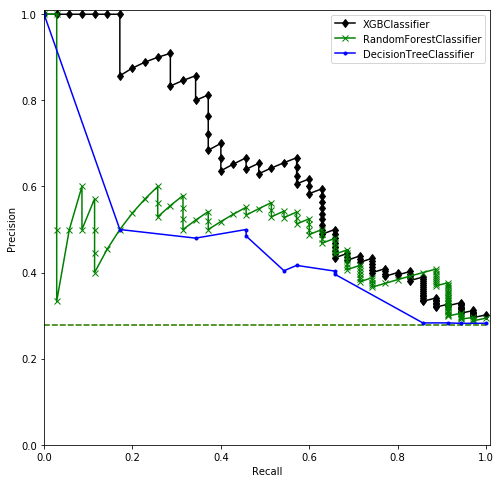

In [59]:
plt.figure(figsize = (8,8))
plot_prc(xgb_with_SMOTE, y_test, 'd' ,'k')
plot_prc(rf_with_SMOTE, y_test, 'x','g')
plot_prc(dt_with_SMOTE, y_test, '.' ,'b')

XGBClassifier: auc=0.644 ap=0.649
RandomForestClassifier: auc=0.620 ap=0.626
DecisionTreeClassifier: auc=0.527 ap=0.411


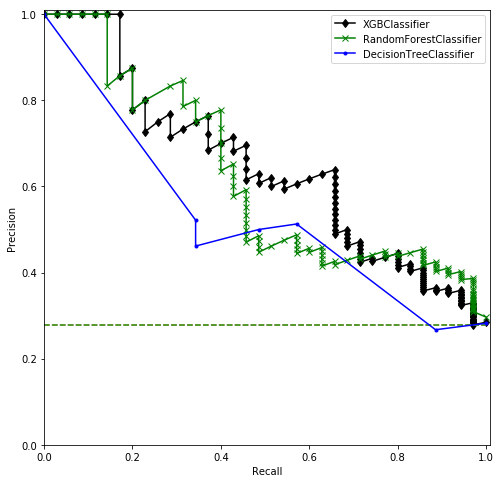

In [60]:
plt.figure(figsize = (8,8))
plot_prc(xgb_no_SMOTE, y_test, 'd' ,'k')
plot_prc(rf_no_SMOTE, y_test, 'x','g')
plot_prc(dt_no_SMOTE, y_test, '.' ,'b')

### Feature Engineering

In [ ]:
# Features
train_eval_test.columns.to_list